In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import utils
from tqdm import tqdm
import os
mpl.rcParams['figure.dpi'] = 100

datapath = "data/"
figpath = "fig/"
if not os.path.isdir(figpath):
    os.mkdir(figpath)

labels = dict(G = r"$G_{year}$ [kWh]", Tw = r"$T_w$ [ºC]", P = r"$E_{year}$ [kWh]", eff = r"$\eta$ [-]")

%load_ext autoreload
%autoreload 2

In [2]:
# Read global mean data.
df = pd.read_csv(datapath + "means-global.csv", skiprows=20)
# Drop self sufficiency; not needed for this notebook
df.drop("suff", axis = 1)

# Drop nans if any
df.dropna(inplace = True)
df.reset_index(inplace = True, drop = True)


# Compute weights according to latitude
lat_weights = np.array(np.cos(2*np.pi*df.lat / 360))
df["lat_weights"] = lat_weights

# Subsample for faster clustering
df_s = utils.subsample_df(df, 0.5)
df_s

,lat,lon,tilt,G,Tamb,Tmod,Tw,E,eff,suff,lat_weights
65,-55.0,-69.0,45.0,1282.195787,1.503263,5.152656,17.307589,1294.701402,1.009753,0.445000,0.573576
70,-55.0,-68.5,31.0,953.602786,1.898424,4.416665,17.355214,955.544077,1.002036,0.333094,0.573576
72,-55.0,-68.0,46.0,1285.492345,2.435207,5.378452,15.401071,1305.722533,1.015737,0.446137,0.573576
77,-55.0,-67.5,46.0,1295.522404,3.331888,6.281185,16.597963,1311.455155,1.012298,0.448372,0.573576
82,-55.0,-66.5,47.0,1355.661772,5.423739,8.273870,17.885172,1367.920436,1.009043,0.463241,0.573576
...,...,...,...,...,...,...,...,...,...,...,...
1436047,73.0,127.0,51.0,913.260306,-11.436274,-9.345125,8.185563,939.332223,1.028548,0.315345,0.292372
1436052,73.0,127.5,51.0,911.670275,-11.512667,-9.429723,8.155586,937.741685,1.028597,0.314715,0.292372
1436057,73.0,128.0,51.0,917.707413,-11.470063,-9.381981,7.959518,944.642391,1.029350,0.317518,0.292372
1436062,73.0,128.5,51.0,929.409465,-11.329249,-9.231407,7.722916,957.669732,1.030407,0.321869,0.292372


In [ ]:
R2_E = utils.compute_R2(df.G, df.E, weights = lat_weights)
R2_eff = utils.compute_R2(df.Tw, df.eff, weights = lat_weights)

print("Correlation coefficients")
print(f"R2 (G, E) = {R2_E:.3f}")
print(f"R2 (Tw, eff) = {R2_eff:.3f}")

df

Correlation coefficients
R2 (G, E) = 0.983
R2 (Tw, eff) = 0.993


,lat,lon,tilt,G,Tamb,Tmod,Tw,E,eff,suff,lat_weights
0,-55.7,-68.1,43.0,1207.817739,5.806924,7.792924,14.218865,1229.134919,1.017649,0.408970,0.563526
1,-55.6,-68.2,43.0,1225.772200,5.187282,7.238182,14.229244,1248.024485,1.018154,0.415664,0.564967
2,-55.6,-68.1,44.0,1236.152576,5.614675,7.765291,14.539113,1258.038544,1.017705,0.419888,0.564967
3,-55.5,-68.8,43.0,1037.319700,5.040403,6.848417,13.920457,1052.648064,1.014777,0.370576,0.566406
4,-55.5,-68.3,43.0,1191.153366,5.394399,7.466031,14.320635,1211.551630,1.017125,0.405046,0.566406
...,...,...,...,...,...,...,...,...,...,...,...
1436593,73.2,126.8,51.0,898.722142,-11.419195,-9.371645,7.883810,924.682445,1.028886,0.311956,0.289032
1436594,73.2,127.3,51.0,896.692005,-11.509064,-9.468931,7.807266,922.724835,1.029032,0.311588,0.289032
1436595,73.2,127.8,51.0,897.131744,-11.447782,-9.412953,7.700692,923.480096,1.029370,0.311868,0.289032
1436596,73.2,128.3,51.0,903.069689,-11.311149,-9.277453,7.400319,930.585312,1.030469,0.314311,0.289032


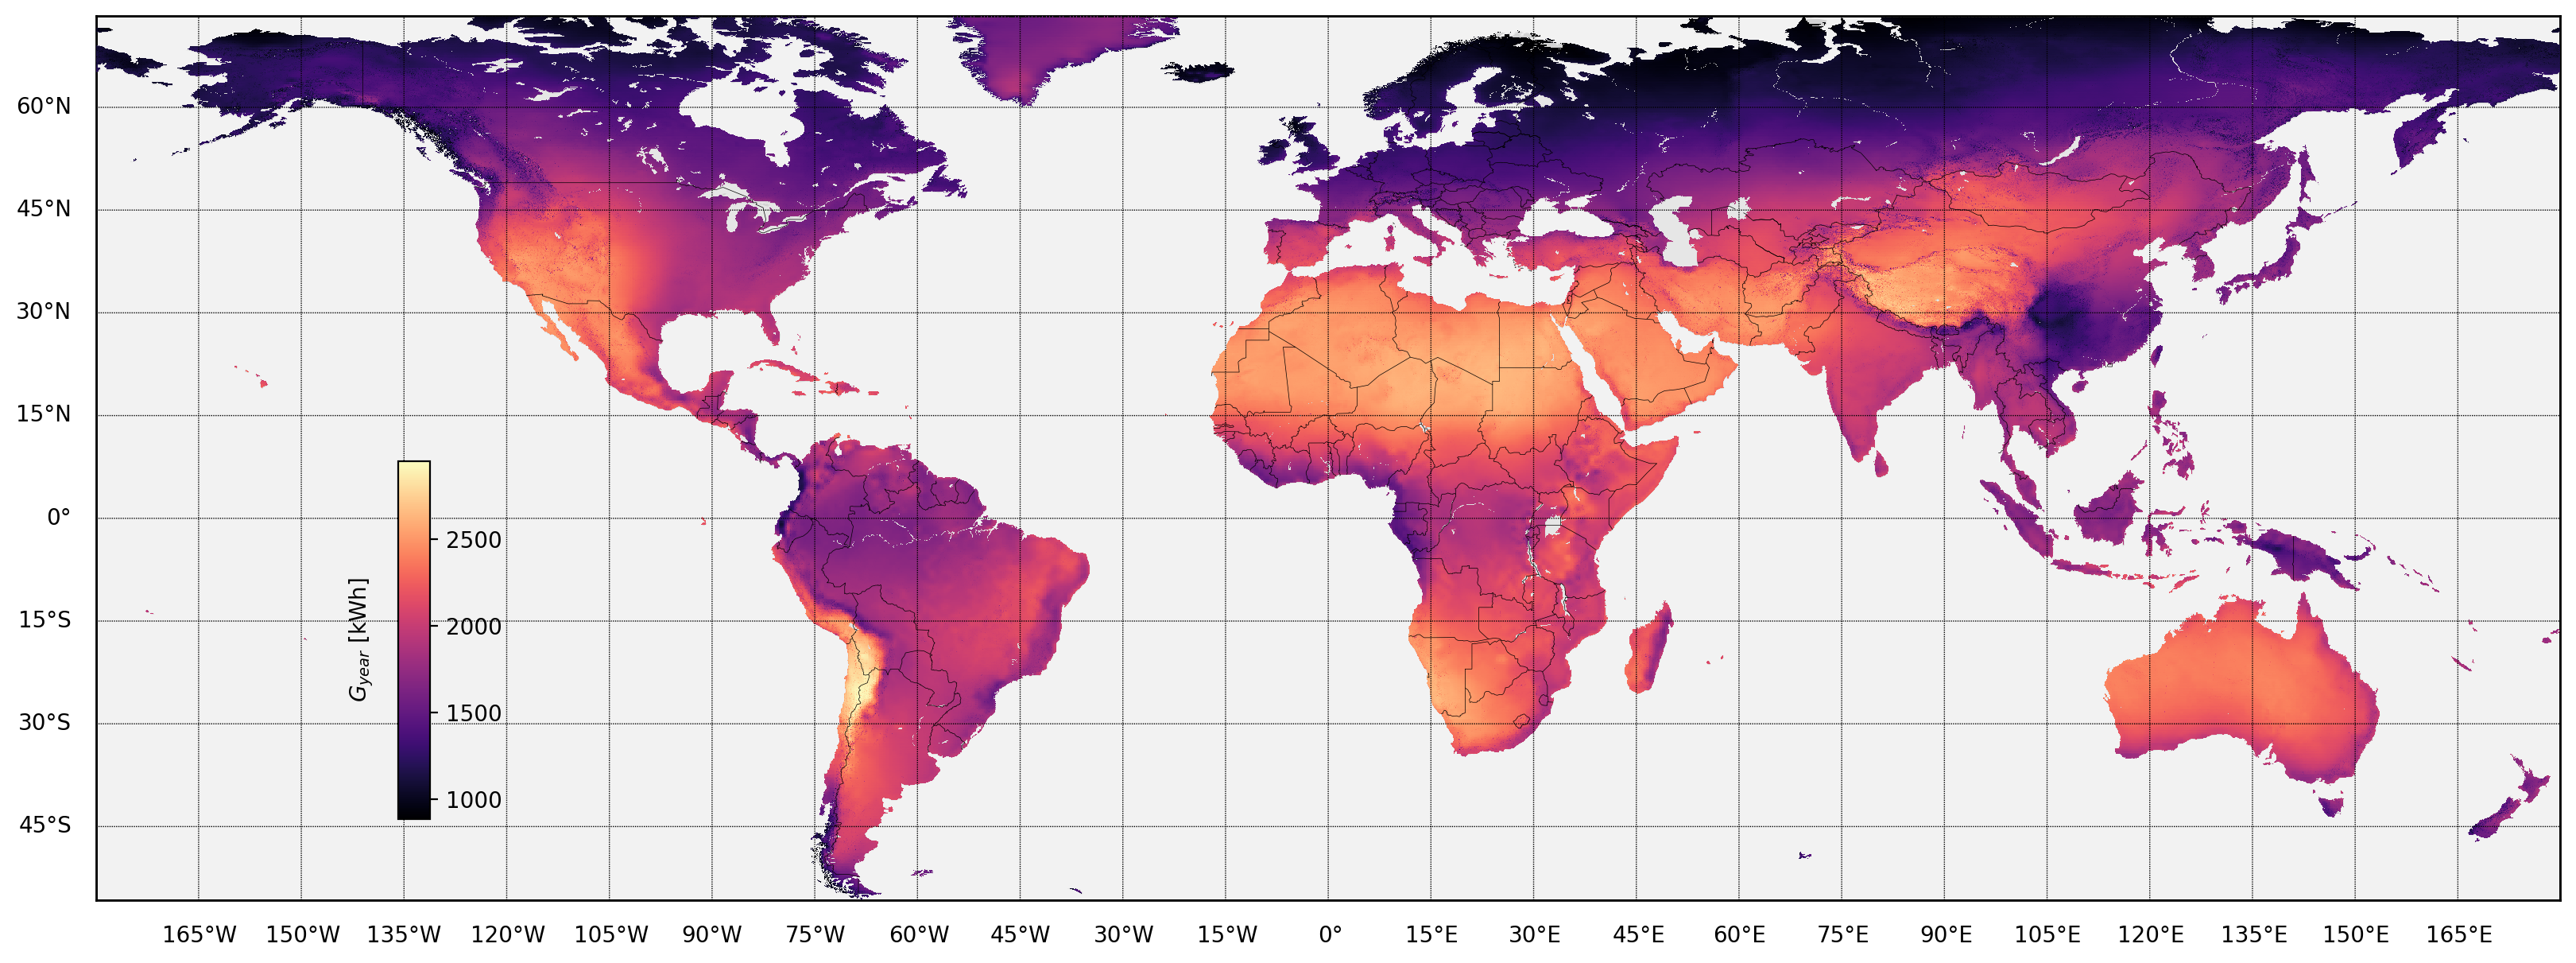

In [8]:
col = "G" # G | Tamb | Tmod | Tw | E | eff | suff
figs = 20
fig, ax = plt.subplots(figsize = (figs,135*figs/360), dpi = 200)
cmap = "magma_r" if col == "eff" else "magma"
if col == "G":
    # Drop extreme outliers for small G for map
    df_img = df.loc[df.G > df.G.quantile(0.001),["lat", "lon", "G"]]
else: 
    df_img = df
img, extent = utils.rasterize(df_img.lat, df_img.lon, df_img[col])

# ax.set_rasterization_zorder(3.5)

ax = utils.drawmap(ax, (*extent[2:], *extent[:2]), projection = "cyl", step_grid = 15, basemap_res = "l")

imshow = ax.imshow(img, origin = "lower", cmap = cmap, extent = extent,
            interpolation = "nearest", zorder = 3)

subax = fig.add_axes((0.22, 0.2, 0.01, 0.3))
plt.colorbar(imshow, cax = subax)
subax.set_ylabel(labels[col], labelpad = -70)

plt.savefig(f"{figpath}global-map-{col}.pdf", bbox_inches = "tight")


In [5]:
# Set random seed for reproducibility
np.random.seed(10)
Nclusters = 10
key = ["G", "Tw"]
dim = len(key)
# Renormalize subsampled data
datai_s = np.array(df_s[key])
scale = np.std(datai_s, axis = 0).reshape(1, -1)
datai_s = datai_s / scale

# Number of KMeans trials
N_trials = 100
results_clustering = dict()
best_score = np.inf

# Try KMeans several times and keep best
for i in tqdm(range(N_trials)):
    index_init = np.random.choice(len(df_s), Nclusters, replace = False)

    _, c, _ = utils.KMeans(datai_s, K = Nclusters, Niter = 20, index_init = index_init, 
                            weights = np.array(df_s.lat_weights),  p = 2)
    D_ij = ((datai_s.reshape(-1, 1, dim) -  c.reshape(1, -1, dim))** 2).sum(-1)
    score = D_ij.min(-1).sum()
    if score < best_score:
        best_score = score
        best_c = c

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:00<00:00,  1.64it/s]


Total representatives 748


/tmp/ipykernel_1391863/406857931.py:46: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  s = df_c.to_latex(index = False)


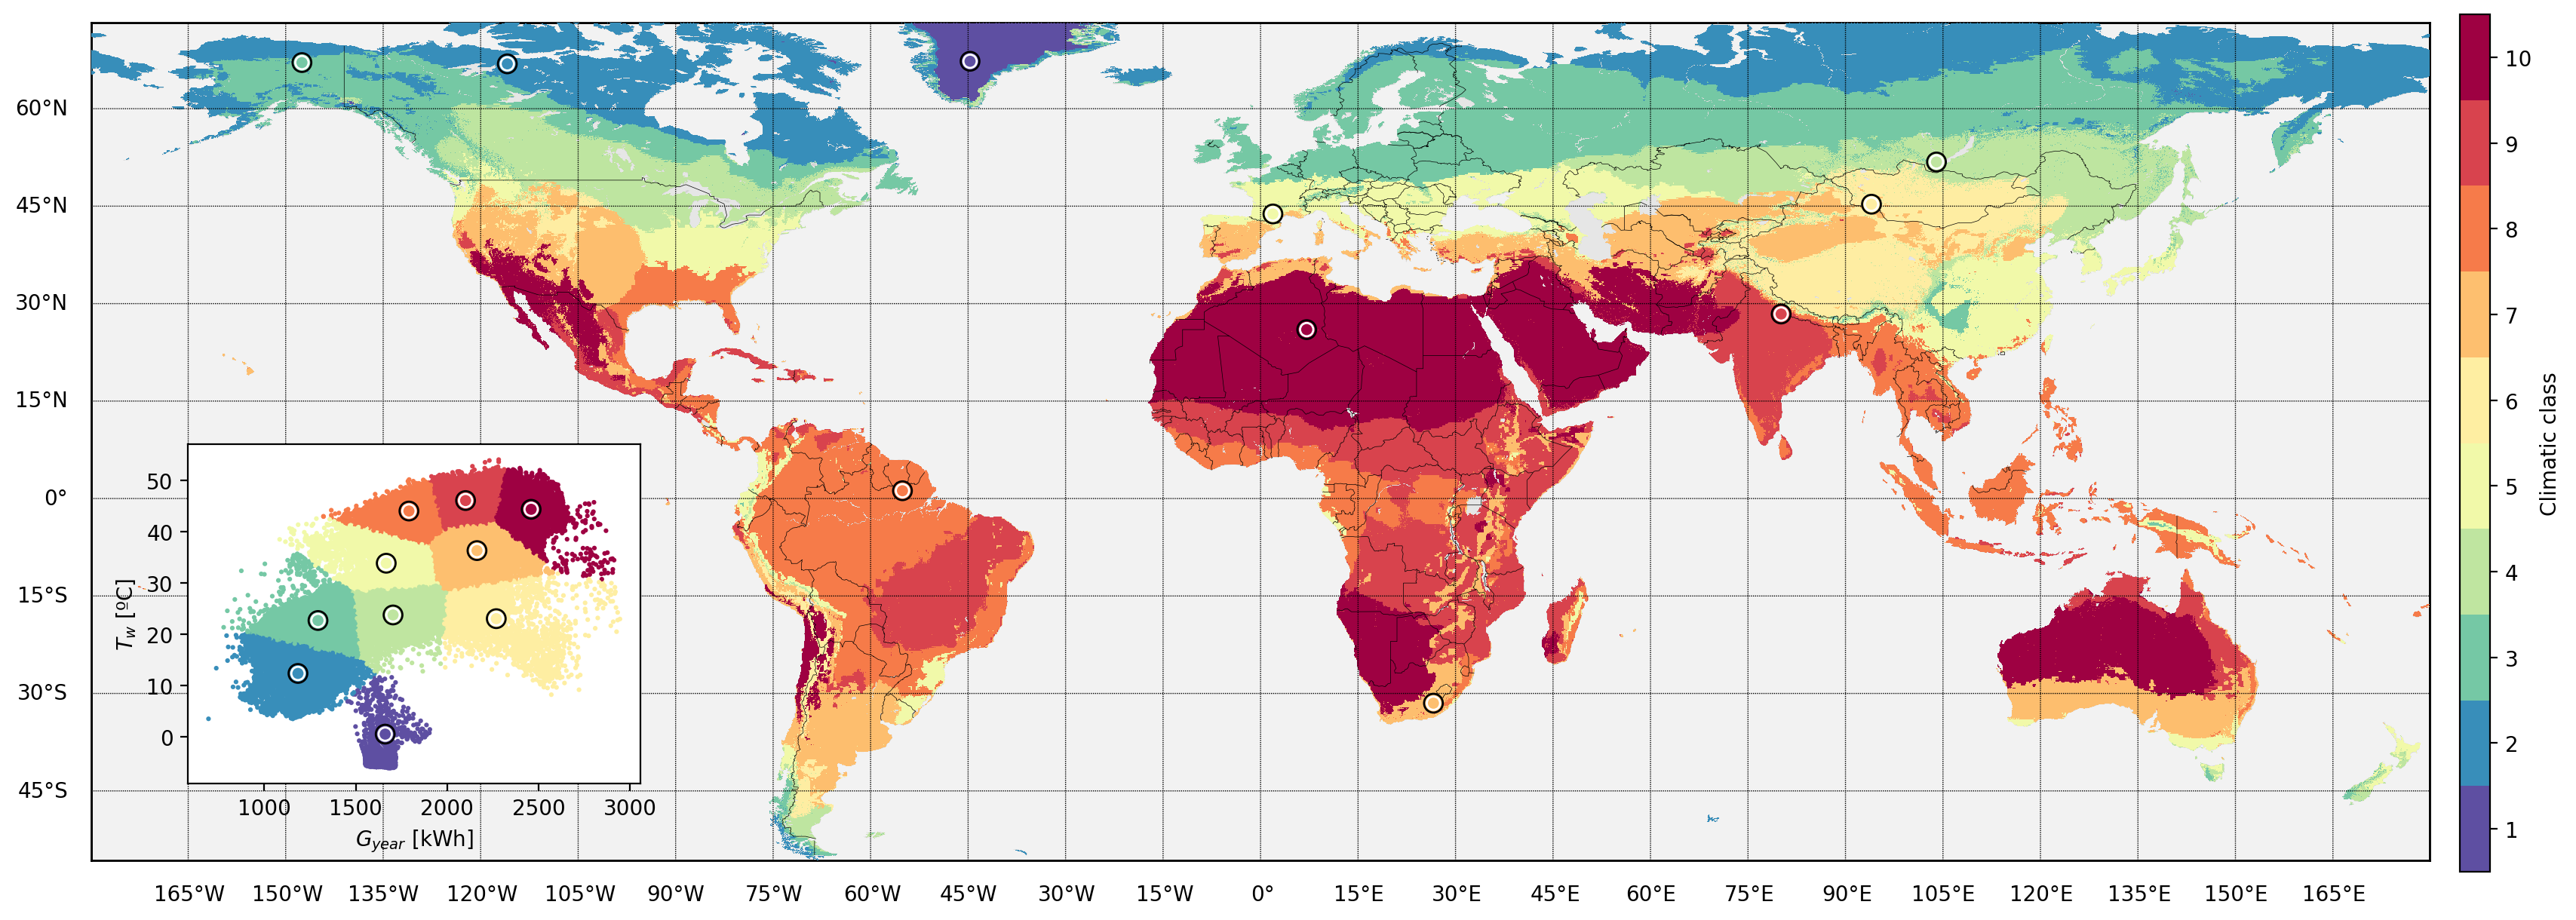

In [ ]:
# Plotting part
figs = 20

write_tex_table = True
savefig = True

fig, ax = plt.subplots(figsize = (figs,figs*135/360), ncols = 1, dpi = 200)


datai = np.array(df[key])
datai /= scale

c_id_sort = np.argsort(best_c @ np.array([1, 1.5]))
c = best_c[c_id_sort]

cl = ((datai.reshape(-1, 1, dim) - c.reshape(1, -1, dim))**2).sum(-1).argmin(axis=1).reshape(-1) 
ind = utils.random_representatives(datai, c, tol=0.01)

coords = df.lat.min(), df.lat.max(), df.lon.min(), df.lon.max()
ax = utils.drawmap(ax, coords, projection = "cyl", step_grid = 15)

# cmap = "Spectral_r"
cmap = plt.cm.get_cmap("Spectral_r", Nclusters)
clim = (0,1)
img,extent = utils.rasterize(df.lat, df.lon, cl+1)
ims = plt.imshow(img, origin = "lower", cmap = cmap, extent = extent,
        interpolation = "nearest", zorder = 3, clim = (0.5, Nclusters+0.5))

# Show centroids on map

ax.scatter(df.lon[ind], df.lat[ind], c = np.arange(Nclusters), marker = "o", edgecolor = "k", linewidth = 1, cmap = cmap, s = 80, clim = (-1, 6), zorder = 100)
ax.scatter(df.lon[ind], df.lat[ind], c = np.arange(Nclusters), marker = "o", edgecolor = "w", linewidth = 1, cmap = cmap, s = 40, clim = (-1, 6), zorder = 200)

if write_tex_table:
    # Create a df
    df_c = np.hstack((
        np.arange(Nclusters).reshape(-1, 1)+1,
        np.array(df.lat[ind]).reshape(-1, 1),
        np.array(df.lon[ind]).reshape(-1, 1),
        np.round(np.array(df.G[ind])).reshape(-1, 1),
        np.round(np.array(df.Tw[ind]),1).reshape(-1, 1),
        ))
    df_c = pd.DataFrame(np.round(df_c,3), columns = ["class", "lat", "lon", r"G", r"T_w"])
    s = df_c.to_latex(index = False)
    s = s.replace(".0 &", " &")
    with open(f"{figpath}/centroids_world.tex", "w") as f:
        f.write(s)

subax = fig.add_axes([0.157,0.20,0.15, 0.3])

cl_s = ((datai_s.reshape(-1, 1, dim) - c.reshape(1, -1, dim))**2).sum(-1).argmin(axis=1).reshape(-1) 

subax.scatter(df_s[key[0]],df_s[key[1]], c = cl_s, s = 5, cmap = cmap, edgecolor = "none")
subax.set_xlabel(labels[key[0]])
subax.set_ylabel(labels[key[1]])

subax.scatter(c[:,0]*scale[0,0], c[:,1]*scale[0,1], c = np.arange(Nclusters), marker = "o", edgecolor = "k", linewidth = 1, cmap = cmap, s = 80, clim = (-1, 6))
subax.scatter(c[:,0]*scale[0,0], c[:,1]*scale[0,1], c = np.arange(Nclusters), marker = "o", edgecolor = "w", linewidth = 1, cmap = cmap, s = 40, clim = (-1, 6))

subax.set_rasterization_zorder(1.5)

# Classification bar
clax = fig.add_axes((0.91,0.122, 0.01, 0.758))
plt.colorbar(ims, cax = clax)
clax.set_ylabel("Climatic class")
clax.set_yticks(np.arange(1,Nclusters+1))

if savefig:
    figname = f"{figpath}clustering-{key[0]}-{key[1]}-opt-Nclusters-{Nclusters}.pdf"

    plt.savefig(figname, bbox_inches = "tight")
plt.show()


# Compare results for different number of clusters

In [ ]:
# Set random seed for reproducibility
np.random.seed(10)
Ncluster_list = np.arange(6,15)

# key = ["P", "eff"]
key = ["G", "Tw"]
dim = len(key)
# Renormalize subsampled data
datai_s = np.array(df_s[key])
scale = np.std(datai_s, axis = 0).reshape(1, -1)
datai_s = datai_s / scale

# Number of KMeans trials
N_trials = 100
results_clustering = dict()
best_score = np.inf
for Nclusters in Ncluster_list:
    # Try KMeans several times and keep best
    print("Nc =", Nclusters)
    for i in tqdm(range(N_trials)):
        index_init = np.random.choice(len(df_s), Nclusters, replace = False)

        _, c, _ = utils.KMeans(datai_s, K = Nclusters, Niter = 20, index_init = index_init, 
                               weights = np.array(df_s.lat_weights),  p = 2)
        D_ij = ((datai_s.reshape(-1, 1, dim) -  c.reshape(1, -1, dim))** 2).sum(-1)
        score = D_ij.min(-1).sum()
        if score < best_score:
            best_score = score
            best_c = c
    print("Computing clusters")

    # Permute centroid based on datai_s
    idx_sort = np.argsort(best_c @ np.array([1, 1.5]))
    c = best_c[idx_sort]
    results_clustering[Nclusters] = dict(c = c)


Nc = 6


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:39<00:00,  2.56it/s]


Computing clusters
Nc = 7


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Computing clusters
Nc = 8


100%|██████████| 100/100 [00:45<00:00,  2.22it/s]


Computing clusters
Nc = 9


100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


Computing clusters
Nc = 10


100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


Computing clusters
Nc = 11


100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


Computing clusters
Nc = 12


100%|██████████| 100/100 [01:12<00:00,  1.39it/s]


Computing clusters
Nc = 13


100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


Computing clusters
Nc = 14


100%|██████████| 100/100 [01:13<00:00,  1.37it/s]

Computing clusters


In [8]:
# Computational part
from tqdm import tqdm
from sklearn.metrics import silhouette_score
distortion = np.zeros(len(Ncluster_list))
inertia = np.zeros(len(Ncluster_list))
silhouette = np.zeros(len(Ncluster_list))
# Subsample for silhouette, since there are too many labels
subsamp = np.random.choice(np.arange(len(datai)), int(len(datai/1000)), replace = False)
for i, Nclusters in tqdm(enumerate(Ncluster_list)):

    c = results_clustering[Nclusters]["c"]
    cl = ((datai_s.reshape(-1, 1, dim) - c.reshape(1, -1, dim))**2).sum(-1).argmin(axis=1).reshape(-1) 
    for j in range(Nclusters):
        inertia_part = np.sum((datai_s[cl == j] - c[[j]])**2)
        inertia[i] += inertia_part
        distortion[i] += inertia_part / np.sum(cl == j)

    silhouette[i] = silhouette_score(datai_s[::5], cl[::5])


9it [00:30,  3.40s/it]


Text(0.5, 0, 'Nclusters')

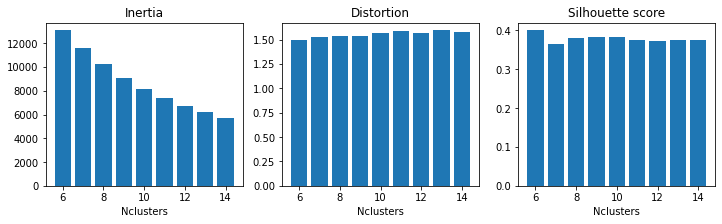

In [9]:

plt.figure(figsize = (12,3))
plt.subplot(131)
plt.bar(Ncluster_list, inertia)
plt.title("Inertia")
plt.xlabel("Nclusters")
plt.subplot(132)
plt.bar(Ncluster_list,distortion)
plt.title("Distortion")
plt.xlabel("Nclusters")
plt.subplot(133)
plt.bar(Ncluster_list,silhouette)
plt.title("Silhouette score")
plt.xlabel("Nclusters")

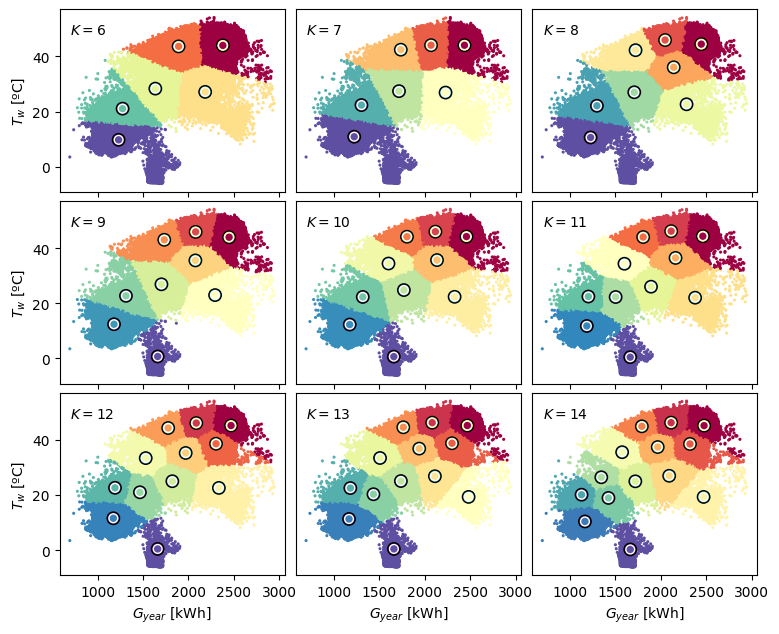

In [ ]:
fig, axs = plt.subplots(3,3,figsize = (9,7.5), dpi = 100, sharex = True)
axs = axs.ravel()

for i, Nclusters in enumerate(Ncluster_list):
    cmap = plt.cm.get_cmap("Spectral_r", Nclusters)
    c = results_clustering[Nclusters]["c"]

    c_id_sort = np.argsort(c @ np.array([1, 1.5]))
    c = c[c_id_sort]

    D_ij = ((datai_s.reshape(-1, 1, dim) - c.reshape(1, -1, dim))**2).sum(-1)
    cl = D_ij.argmin(axis=1).reshape(-1) 

    ax = axs[i]
    ax.scatter(df_s[key[0]], df_s[key[1]], c = cl, s = 5, cmap = cmap, edgecolor = "none", zorder = -1)
    ax.set_rasterization_zorder(0)
    ax.set_xlabel(labels[key[0]])
    if i % 3 == 0:
        ax.set_ylabel(labels[key[1]])
    else:
        ax.set_ylabel("")
        ax.set_yticks([])
    ax.text(700, 48, r"$K = " + str(Nclusters) + "$")
    ax.scatter(c[:,0]*scale[0,0], c[:,1]*scale[0,1], c = np.arange(Nclusters), marker = "o", edgecolor = "k", linewidth = 1, s = 80)
    ax.scatter(c[:,0]*scale[0,0], c[:,1]*scale[0,1], c = np.arange(Nclusters), marker = "o", edgecolor = "w", linewidth = 1, s = 40, cmap = cmap)
plt.subplots_adjust(wspace = 0.05, hspace = 0.05)
plt.savefig(f"{figpath}comparison-clusters-{key[0]}-{key[1]}-Nclusters-{','.join(map(str,Ncluster_list))}.pdf", bbox_inches = "tight")
plt.show()